In [ ]:
import yfinance as yahooFinance
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from scipy import stats

import seaborn as sns
from scipy.stats import norm, t, gennorm
import statsmodels.api as sm
import scipy.stats as stats

import itertools
import statsmodels.api as sm



In [ ]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
from arch import arch_model

In [ ]:
start = "2004-02-01"
end = '2024-09-08'

VGT = yahooFinance.download('VGT', start=start, end=end)['Adj Close']
SPX = yahooFinance.download('^SPX', start=start, end=end)['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
returns_VGT = VGT.pct_change().dropna()
returns_SPX = SPX.pct_change().dropna()

In [ ]:
returns_VGT_rescaled = returns_VGT * 100

In [ ]:
VGT_model_APARCH_1 = arch_model(returns_VGT_rescaled, vol='APARCH', p=1, q=1, dist='skewt')
VGT_model_APARCH_result_1 = VGT_model_APARCH_1.fit(disp='off')

                         Constant Mean - Power ARCH Model Results                        
Dep. Variable:                         Adj Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            Power ARCH   Log-Likelihood:               -8124.01
Distribution:      Standardized Skew Student's t   AIC:                           16262.0
Method:                       Maximum Likelihood   BIC:                           16307.9
                                                   No. Observations:                 5184
Date:                           Mon, Oct 14 2024   Df Residuals:                     5183
Time:                                   13:54:37   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

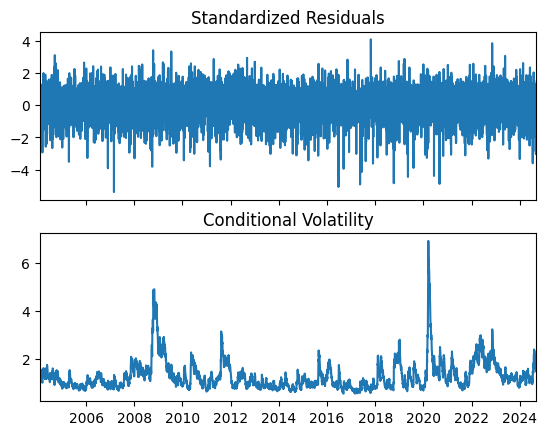

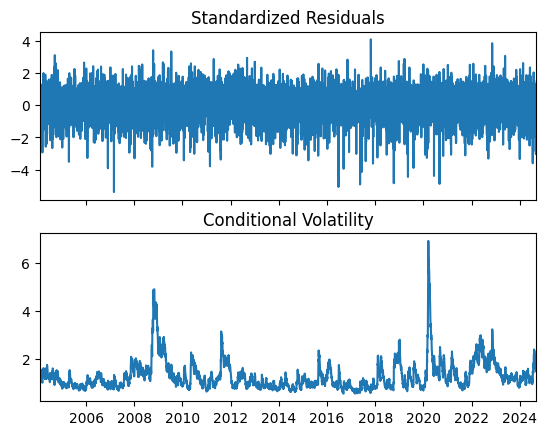

In [ ]:
print(VGT_model_APARCH_result_1.summary())
VGT_model_APARCH_result_1.plot()

One-step ahead forecast

In [ ]:
volatility_forecasts_1_ahead = VGT_model_APARCH_result_1.forecast(horizon=1)

# Extract the forecasted conditional standard deviation (volatility)
forecasted_volatility_series_1_ahead = volatility_forecasts_1_ahead.variance[-1:].T.apply(lambda x: x**0.5)

# Display the forecasted volatility
print(forecasted_volatility_series_1_ahead)

Date  2024-09-06
h.1     1.845256


multipe step (manual) forecasting
generate the forecasts iteratively, updating the model at each step

In [ ]:
forecast_horizon = 10

# Initialize a list to store forecasted conditional volatility
forecasted_volatility_series = []

# Start with the most recent fitted model results
current_model = VGT_model_APARCH_result_1

# Generate iterative forecasts
for _ in range(forecast_horizon):
    # Forecast one step ahead
    next_forecast = current_model.forecast(horizon=1)

    # Extract the forecasted variance and take the square root to get volatility
    next_volatility = np.sqrt(next_forecast.variance.iloc[-1, 0])

    # Store the forecasted volatility
    forecasted_volatility_series.append(next_volatility)

    # Update the model with the new data (forecast becomes actual observation)
    new_observation = np.random.normal(0, next_volatility)  # Simulate a new return
    current_model = arch_model(np.append(current_model.resid, new_observation), vol='APARCH', p=1, q=1, dist='skewt').fit(disp='off')

# Convert the results into a Pandas Series for easier handling
forecasted_volatility_series = pd.Series(forecasted_volatility_series, name="Forecasted Volatility")


0    1.845256
1    1.914160
2    1.805711
3    2.017824
4    2.100529
5    1.991288
6    2.117620
7    2.012527
8    1.958594
9    2.139759
Name: Forecasted Volatility, dtype: float64


In [ ]:
# Display the forecasted conditional volatilities
print(forecasted_volatility_series)

2024-09-09    1.845256
2024-09-10    1.914160
2024-09-11    1.805711
2024-09-12    2.017824
2024-09-13    2.100529
2024-09-16    1.991288
2024-09-17    2.117620
2024-09-18    2.012527
2024-09-19    1.958594
2024-09-20    2.139759
Freq: B, Name: Forecasted Volatility, dtype: float64


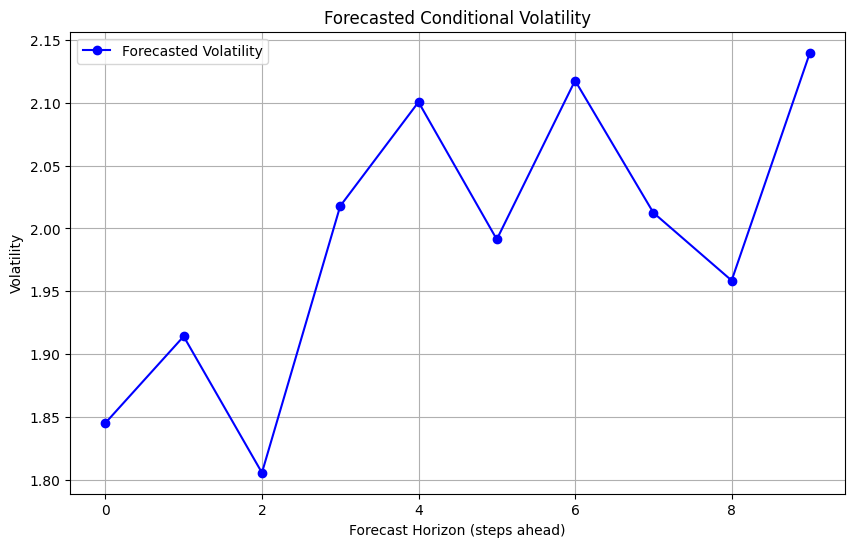

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(forecasted_volatility_series, marker='o', linestyle='-', color='b', label='Forecasted Volatility')
plt.title('Forecasted Conditional Volatility')
plt.xlabel('Forecast Horizon (steps ahead)')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
conditional_volatility_model = VGT_model_APARCH_result_1.conditional_volatility

In [ ]:
last_100_volatility = conditional_volatility_model[-100:]

In [ ]:
# Concatenate the last 100 observations with the forecasted volatility
combined_volatility = pd.concat([last_100_volatility, forecasted_volatility_series], ignore_index=True)

In [ ]:
# Create a new index for the forecasted series using the last historical timestamp and a frequency
last_date = last_100_volatility.index[-1]
forecast_index = pd.date_range(start=last_date, periods=len(forecasted_volatility_series) + 1, freq='B')[1:]

# Convert the forecasted volatility to a series with the new index
forecasted_volatility_series.index = forecast_index

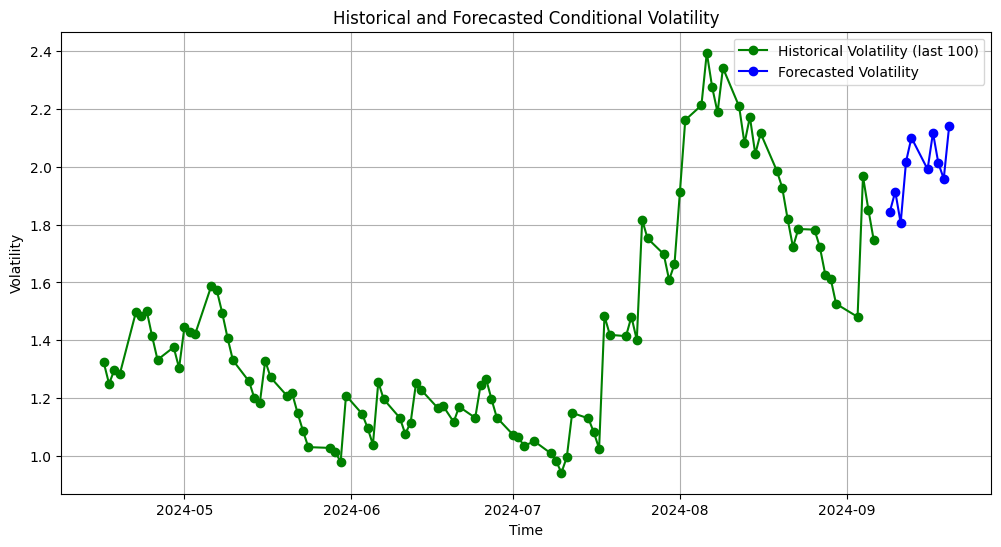

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(last_100_volatility.index, last_100_volatility, label='Historical Volatility (last 100)', marker='o',color='g')
plt.plot(forecasted_volatility_series.index, forecasted_volatility_series, label='Forecasted Volatility', color='b', marker='o', linestyle='-')
plt.title('Historical and Forecasted Conditional Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
params = VGT_model_APARCH_result_1.params

# Parameters: location (mean), scale, skew, and shape (degree of freedom for t-distribution)
location = params[0]  # location (mean) -mu
scale = params[1]     # scale -omega
skew = params[2]      # skewness -alpha1
shape = params[3]     # shape parameter (degrees of freedom)  -beta1

# Number of future returns to simulate (matching the forecast horizon)
num_simulations = len(forecasted_volatility_series)

<ipython-input-26-c9be943ffae9>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  location = params[0]  # location (mean)
<ipython-input-26-c9be943ffae9>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = params[1]     # scale
<ipython-input-26-c9be943ffae9>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  skew = params[2]      # skewness
<ipython-input-26-c9be943ffae9>:7: FutureWarning: Series.__getitem__ treating keys as posi

In [ ]:
print(f"Location: {location:.4f}")
print(f"Scale: {scale:.4f}")
print(f"Skew: {skew:.4f}")
print(f"Shape: {shape:.4f}")

Location: 0.0946
Scale: 0.0237
Skew: 0.1083
Shape: 0.8906


In [ ]:
# Simulate standardized returns from the skew-t distribution
standardized_returns = skew * t.rvs(df=shape, size=num_simulations) + location

# Scale the standardized returns by the forecasted conditional volatility to get future returns
simulated_returns = standardized_returns * forecasted_volatility_series.values


In [ ]:
print(simulated_returns)

[ 0.45139647 -0.18776025  0.48645572 -3.44435975  0.11336563  0.03001757
 -0.05825534  0.0355505  -1.60200612  0.52707187]


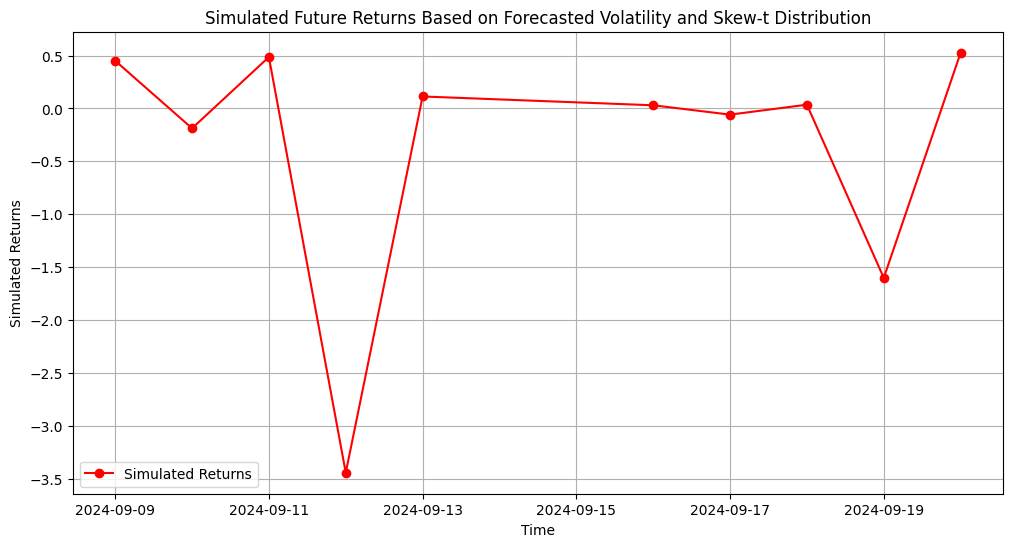

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(forecasted_volatility_series.index, simulated_returns, marker='o', linestyle='-', color='r', label='Simulated Returns')
plt.title('Simulated Future Returns Based on Forecasted Volatility and Skew-t Distribution')
plt.xlabel('Time')
plt.ylabel('Simulated Returns')
plt.legend()
plt.grid(True)
plt.show()